In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.append('/home/mitch/school/data/mexico_enigh/')
import src.utils as utils

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
#sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
os.chdir(processed)
df = pd.read_csv('data.csv')


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26857 entries, 0 to 26856
Data columns (total 92 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_education                                    26857 non-null  float64
 1   income_total                                             26857 non-null  float64
 2   consumption_transportation                               26857 non-null  float64
 3   consumption_house                                        26857 non-null  float64
 4   income_salary                                            26857 non-null  float64
 5   consumption_current                                      26857 non-null  float64
 6   consumption_clothing                                     26857 non-null  float64
 7   financial_expenditures                                   26857 non-null  float64
 8   financial_income          

In [35]:
df['post'] = df['Y'] == 1996
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
df = (df.query('income > 0')
      .query('consumption > 0')
      .query('age >= 25')
      .query('age <= 60'))
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

df['year_weight'] = df.groupby('Y')['weight'].transform(np.sum) / df['weight'].sum()

In [37]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

13423


In [38]:
get_average = [x for x in df.columns if ('has_expense' in x) or ('has_income' in x)]
averages = pd.DataFrame(index=get_average)

averages['mean'] = [
     np.average(df[x], axis=0, weights=df['year_weight'] * df['weight'])
    for x in get_average
]
averages = averages.sort_values('mean', ascending=False)
df['has_any'] = (df[get_average].sum(axis=1) > 0) + 0
averages

,mean
has_expense_deposits_savings,0.329205
has_expense_credit_card_payments,0.109859
has_income_from_loans_to_third_parties_not_in_household,0.086311
has_expense_debt_to_work_or_person,0.078900
has_income_withdrawal_savings,0.063561
has_income_coins_preciousmetals_art,0.052682
has_income_from_loans_to_institutions_not_mortgage,0.039449
has_expense_loans_to_third_parties,0.029590
has_expense_hhbusiness_negative_balance,0.022454
has_income_rental_houses_buildings_other_realestate,0.018688


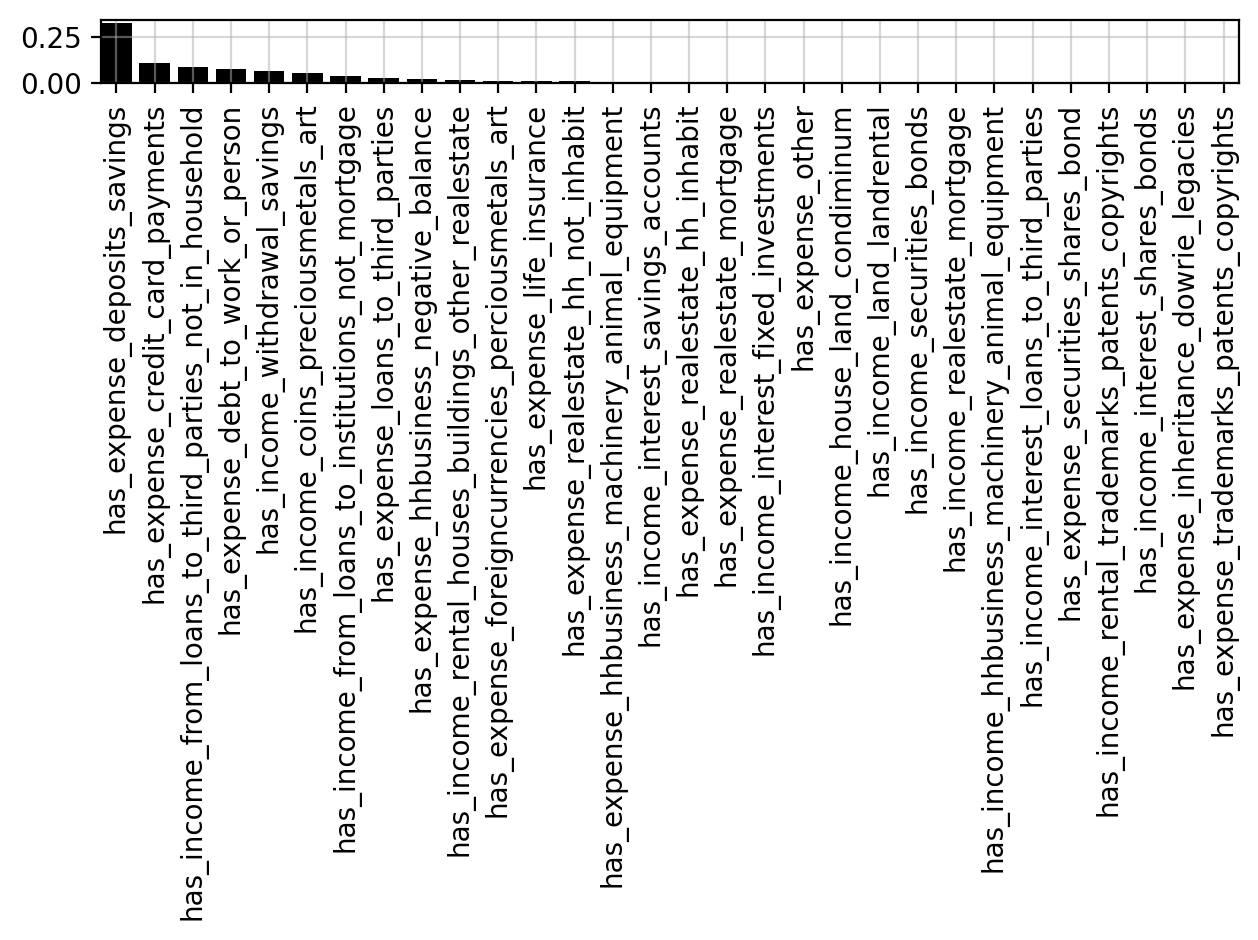

In [39]:
plt.clf()
plt.bar(averages.index.values, averages['mean'])
plt.xticks(rotation=90)
plt.show()

In [40]:
(df.query('Y == 1994')[get_average].sum(axis=1) > 0).mean()

0.5039304231476835

In [41]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import probit, identity
probit_model = sm.families.Binomial(probit()) # basic probit model
linear_model = sm.families.Gaussian(identity()) # basic linear model

In [42]:
y = 'has_expense_deposits_savings'
Z = '~ C(decile) + age + I(age**2) + C(education) + C(sex) + C(location_size)'
D = ' + C(Y)'

reg = y + Z + D

models = {}

models['deposits'] = smf.glm('has_expense_deposits_savings' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()
models['creditcard'] = smf.glm('has_expense_credit_card_payments' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()
models['any'] = smf.glm('has_any' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()

In [43]:
models['deposits'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                       
========================================================================================
Dep. Variable:     has_expense_deposits_savings   No. Observations:                13423
Model:                                      GLM   Df Residuals:                 23963573
Model Family:                          Binomial   Df Model:                           17
Link Function:                           probit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:            -1.4180e+07
Date:                          Tue, 26 Dec 2023   Deviance:                   2.8360e+07
Time:                                  18:08:20   Pearson chi2:                 2.40e+07
No. Iterations:                               6   Pseudo R-squ. (CS):              1.000
Covariance Type:                      nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.9145      0.005   -169.524      0.000      -0.925      -0.904
C(decile)[T.2]             0.1778      0.001    130.361      0.000       0.175       0.180
C(decile)[T.3]             0.2066      0.001    150.730      0.000       0.204       0.209
C(decile)[T.4]             0.4822      0.001    359.517      0.000       0.480       0.485
C(decile)[T.5]             0.5550      0.001    413.852      0.000       0.552       0.558
C(decile)[T.6]             0.6481      0.001    483.244      0.000       0.645       0.651
C(decile)[T.7]             0.8454      0.001    630.309      0.000       0.843       0.848
C(decile)[T.8]             0.9251      0.001    683.113      0.000       0.922       0.928
C(decile)[T.9]             1.0433      0.001    754.886      0.000       1.041       1.046
C(decile)[T.10]            1.3671      0.001    930.047      0.000       1.364       1.370
C(education)[T.low]        0.0732      0.001     78.013      0.000       0.071       0.075
C(education)[T.medium]    -0.0285      0.001    -32.401      0.000      -0.030      -0.027
C(sex)[T.2]               -0.1583      0.001   -198.413      0.000      -0.160      -0.157
C(location_size)[T.2]      0.0807      0.001    108.293      0.000       0.079       0.082
C(location_size)[T.3]      0.1781      0.001    221.645      0.000       0.177       0.180
C(Y)[T.1996]               0.0626      0.001    114.303      0.000       0.062       0.064
age                       -0.0038      0.000    -15.011      0.000      -0.004      -0.003
I(age ** 2)            -6.385e-05   3.03e-06    -21.065      0.000   -6.98e-05   -5.79e-05
==========================================================================================
"""

In [44]:
models['creditcard'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                         
============================================================================================
Dep. Variable:     has_expense_credit_card_payments   No. Observations:                13423
Model:                                          GLM   Df Residuals:                 23963573
Model Family:                              Binomial   Df Model:                           17
Link Function:                               probit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:            -5.4856e+06
Date:                              Tue, 26 Dec 2023   Deviance:                   1.0971e+07
Time:                                      18:08:20   Pearson chi2:                 2.86e+07
No. Iterations:                                  10   Pseudo R-squ. (CS):              1.000
Covariance Type:                          nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.7168      0.010   -485.009      0.000      -4.736      -4.698
C(decile)[T.2]             0.2035      0.005     41.397      0.000       0.194       0.213
C(decile)[T.3]             0.2892      0.005     61.310      0.000       0.280       0.298
C(decile)[T.4]             0.4929      0.004    110.841      0.000       0.484       0.502
C(decile)[T.5]             0.5667      0.004    129.730      0.000       0.558       0.575
C(decile)[T.6]             0.7620      0.004    177.775      0.000       0.754       0.770
C(decile)[T.7]             0.9887      0.004    234.814      0.000       0.980       0.997
C(decile)[T.8]             1.2481      0.004    299.582      0.000       1.240       1.256
C(decile)[T.9]             1.5455      0.004    372.604      0.000       1.537       1.554
C(decile)[T.10]            2.0029      0.004    481.206      0.000       1.995       2.011
C(education)[T.low]       -0.9456      0.001   -735.986      0.000      -0.948      -0.943
C(education)[T.medium]    -0.4686      0.001   -454.573      0.000      -0.471      -0.467
C(sex)[T.2]               -0.1975      0.001   -153.239      0.000      -0.200      -0.195
C(location_size)[T.2]     -0.4175      0.001   -306.913      0.000      -0.420      -0.415
C(location_size)[T.3]     -0.5962      0.002   -306.796      0.000      -0.600      -0.592
C(Y)[T.1996]              -0.2950      0.001   -346.255      0.000      -0.297      -0.293
age                        0.1433      0.000    336.989      0.000       0.142       0.144
I(age ** 2)               -0.0015   5.05e-06   -304.198      0.000      -0.002      -0.002
==========================================================================================
"""

In [46]:
models['any'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                has_any   No. Observations:                13423
Model:                            GLM   Df Residuals:                 23963573
Model Family:                Binomial   Df Model:                           17
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5196e+07
Date:                Tue, 26 Dec 2023   Deviance:                   3.0391e+07
Time:                        18:08:28   Pearson chi2:                 2.40e+07
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.0321      0.005   -197.000      0.000      -1.042      -1.022
C(decile)[T.2]            -0.0166      0.001    -13.963      0.000      -0.019      -0.014
C(decile)[T.3]             0.0848      0.001     71.082      0.000       0.082       0.087
C(decile)[T.4]             0.2060      0.001    172.018      0.000       0.204       0.208
C(decile)[T.5]             0.2873      0.001    239.044      0.000       0.285       0.290
C(decile)[T.6]             0.3934      0.001    325.787      0.000       0.391       0.396
C(decile)[T.7]             0.5778      0.001    472.534      0.000       0.575       0.580
C(decile)[T.8]             0.7254      0.001    582.394      0.000       0.723       0.728
C(decile)[T.9]             0.8875      0.001    687.176      0.000       0.885       0.890
C(decile)[T.10]            1.3791      0.001    939.599      0.000       1.376       1.382
C(education)[T.low]       -0.2042      0.001   -214.939      0.000      -0.206      -0.202
C(education)[T.medium]    -0.2003      0.001   -220.770      0.000      -0.202      -0.198
C(sex)[T.2]               -0.2304      0.001   -302.184      0.000      -0.232      -0.229
C(location_size)[T.2]      0.0862      0.001    120.330      0.000       0.085       0.088
C(location_size)[T.3]      0.2089      0.001    272.751      0.000       0.207       0.210
C(Y)[T.1996]               0.0107      0.001     20.183      0.000       0.010       0.012
age                        0.0434      0.000    175.184      0.000       0.043       0.044
I(age ** 2)               -0.0006   2.93e-06   -193.443      0.000      -0.001      -0.001
==========================================================================================
"""

In [48]:
y = 'log_income'
Z = '~ age + I(age**2) + C(education) + C(sex) + C(location_size)'
D = ' + C(Y)'

reg = y + Z + D

income_model = smf.glm(reg, df, missing='drop', freq_weights=df['weight'], family=linear_model).fit()
df['log_income_residual'] = income_model.resid_working
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                13423
Model:                            GLM   Df Residuals:                 23963582
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                         0.57011
Method:                          IRLS   Log-Likelihood:            -2.7270e+07
Date:                Tue, 26 Dec 2023   Deviance:                   1.3662e+07
Time:                        18:08:45   Pearson chi2:                 1.37e+07
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.5050      0.003   1858.644      0.000       5.499       5.511
C(education)[T.low]       -1.3654      0.000  -3001.172      0.000      -1.366      -1.364
C(education)[T.medium]    -0.8190      0.000  -1740.000      0.000      -0.820      -0.818
C(sex)[T.2]                0.0924      0.000    209.720      0.000       0.092       0.093
C(location_size)[T.2]     -0.2512      0.000   -604.954      0.000      -0.252      -0.250
C(location_size)[T.3]     -0.4733      0.000  -1089.158      0.000      -0.474      -0.472
C(Y)[T.1996]              -0.3325      0.000  -1075.544      0.000      -0.333      -0.332
age                       -0.0291      0.000   -202.745      0.000      -0.029      -0.029
I(age ** 2)                0.0005    1.7e-06    304.593      0.000       0.001       0.001
==========================================================================================
"""

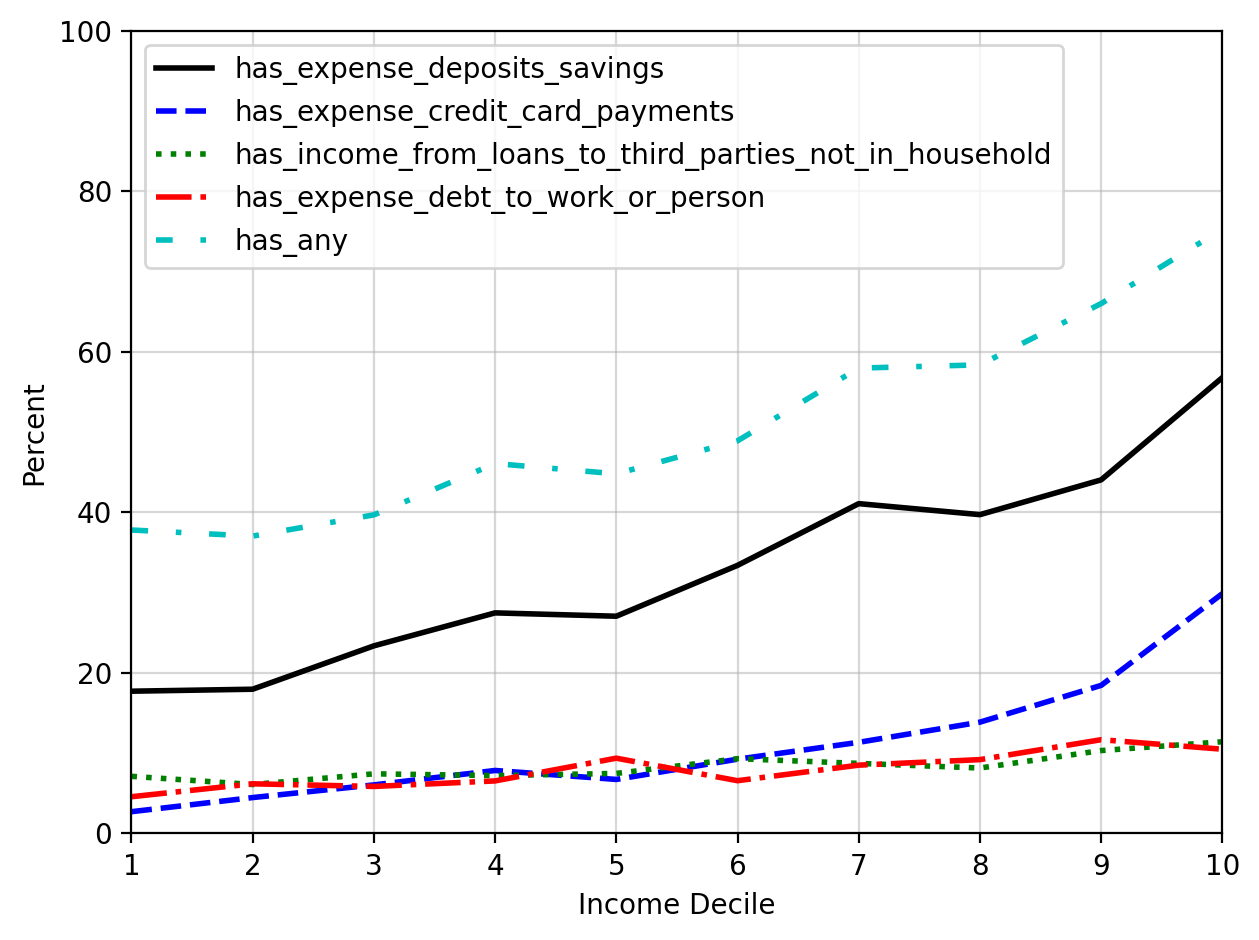

In [63]:
to_by_decile = ['has_expense_deposits_savings',
                'has_expense_credit_card_payments',
                'has_income_from_loans_to_third_parties_not_in_household',
                'has_expense_debt_to_work_or_person',
                'has_any'
                ]

deciles = np.arange(1, 11)                

plt.clf()
for x in to_by_decile:
    plt.plot(deciles, 100 * utils.indicator_by_decile(df, 'log_income_residual', x, 'weight'), label=x)
plt.legend()
plt.ylim(0, 100)
plt.xticks(np.arange(1, 11))

plt.xlabel('Income Decile')
plt.ylabel('Percent')

plt.show()